In [1]:
# Cell 1: Load all three pickles
import pandas as pd
import numpy as np

# Load the three data sources
df_has = pd.read_pickle('asset-coverage.pkl')  # What techs assets HAVE
df_rules = pd.read_pickle('component_map.pkl')  # Component -> Tech rules
df_components = pd.read_pickle('asset_components.pkl')  # Asset -> Components

print("Loaded data:")
print(f"  Assets with HAS data: {len(df_has)}")
print(f"  Component rules: {len(df_rules)}")
print(f"  Assets with component mapping: {len(df_components)}")
print(f"  Assets with components assigned: {(df_components['COMPONENT_TYPES'].apply(len) > 0).sum()}")

Loaded data:
  Assets with HAS data: 1185
  Component rules: 23
  Assets with component mapping: 25661
  Assets with components assigned: 14243


In [2]:
# Cell 2 CORRECTED: Function to determine what techs an asset NEEDS based on its components
def get_asset_tech_needs(component_list, rules_df, include_secondary=True):
    """
    Given list of component types for an asset, determine which technologies are needed
    
    Returns dict: {'IR': 'S', 'VI': 'P', 'LU': 'N', ...}
    Uses highest priority rating if multiple components need same tech
    Priority: P (Primary) > S (Secondary) > N
    """
    tech_cols = ['IR', 'LU', 'VI', 'UL', 'MC', 'ZD', 'GM']
    
    # Start with all N
    asset_needs = {tech: 'N' for tech in tech_cols}
    
    # If no components, return all N
    if not component_list or len(component_list) == 0:
        return asset_needs
    
    # For each component, get its tech needs
    for component in component_list:
        # Find this component in rules
        comp_row = rules_df[rules_df['Component Type'] == component]
        
        if comp_row.empty:
            continue  # Component not found in rules, skip
        
        # Get tech ratings for this component
        for tech in tech_cols:
            component_rating = comp_row[tech].iloc[0]
            current_rating = asset_needs[tech]
            
            # Update if this component has higher priority
            # Priority: P (Primary) > S (Secondary) > N
            if component_rating == 'P':  # CHANGED: P is now highest priority
                asset_needs[tech] = 'P'
            elif component_rating == 'S' and current_rating == 'N':  # CHANGED: S is now secondary
                asset_needs[tech] = 'S'
    
    # If include_secondary is False, convert S to N (keep only Primary)
    if not include_secondary:
        asset_needs = {k: ('N' if v == 'S' else v) for k, v in asset_needs.items()}  # CHANGED: S→N instead of P→N
    
    return asset_needs

# Test it
test_components = ['Centrifugal Pumps', 'Electric Motors (AC Induction)']
test_needs = get_asset_tech_needs(test_components, df_rules)
print("\nTest: Asset with Centrifugal Pump + AC Motor needs:")
print(test_needs)
print("(P = Primary application, S = Secondary application)")


Test: Asset with Centrifugal Pump + AC Motor needs:
{'IR': 'S', 'LU': 'P', 'VI': 'P', 'UL': 'S', 'MC': 'S', 'ZD': 'N', 'GM': 'N'}
(P = Primary application, S = Secondary application)


In [3]:
# Cell 3: Apply to all assets to determine NEED columns
print("Calculating technology needs for all assets...")

tech_cols = ['IR', 'LU', 'VI', 'UL', 'MC', 'ZD', 'GM']

# Create NEED columns
for tech in tech_cols:
    df_components[f'{tech}_NEED'] = df_components['COMPONENT_TYPES'].apply(
        lambda comps: get_asset_tech_needs(comps, df_rules).get(tech, 'N')
    )

print("✓ NEED columns created")
print("\nSample of assets with NEED ratings:")
print(df_components[['ASSETNUM', 'ASSET_CLASS', 'IR_NEED', 'VI_NEED', 'UL_NEED']].head(10))

Calculating technology needs for all assets...
✓ NEED columns created

Sample of assets with NEED ratings:
  ASSETNUM    ASSET_CLASS IR_NEED VI_NEED UL_NEED
0  A100121          Panel       P       N       S
1  A100001       Conveyor       S       P       P
2  A100002  Head Assembly       N       N       P
3  A100003  Head Assembly       N       N       P
4  A100004  Head Assembly       N       N       P
5  A100005          Press       P       P       P
6  A100006          Press       P       P       P
7  A100007     Power Tool       N       N       N
8  A100008        Grinder       S       P       P
9  A100009     Power Tool       N       N       N


In [4]:
# Cell 4: Merge with HAS data
# df_has has columns: ASSETNUM, DESCRIPTION, CLASS, DEPT, IR_HAS, UL_HAS, VI_HAS, etc.
# df_components has: ASSETNUM, DESCRIPTION, ASSET_CLASS, DEPT, COMPONENT_TYPES, IR_NEED, etc.

# Merge on ASSETNUM
df_matrix = df_components.merge(
    df_has[['ASSETNUM', 'IR_HAS', 'LU_HAS', 'VI_HAS', 'UL_HAS', 'MC_HAS', 'ZD_HAS', 'GM_HAS']], 
    on='ASSETNUM', 
    how='left'
)

# Fill NaN in HAS columns with 'N' (assets not on any route)
for tech in tech_cols:
    df_matrix[f'{tech}_HAS'].fillna('N', inplace=True)

print(f"✓ Merged matrix created with {len(df_matrix)} assets")
print("\nColumns in matrix:")
print(df_matrix.columns.tolist())

✓ Merged matrix created with 25661 assets

Columns in matrix:
['ASSETNUM', 'DESCRIPTION', 'ASSET_CLASS', 'DEPT', 'COMPONENT_TYPES', 'IR_NEED', 'LU_NEED', 'VI_NEED', 'UL_NEED', 'MC_NEED', 'ZD_NEED', 'GM_NEED', 'IR_HAS', 'LU_HAS', 'VI_HAS', 'UL_HAS', 'MC_HAS', 'ZD_HAS', 'GM_HAS']


C:\Users\VF033899\AppData\Local\Temp\ipykernel_28108\3233704122.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_matrix[f'{tech}_HAS'].fillna('N', inplace=True)


In [5]:
# Cell 5: Calculate gap columns (NEED but don't HAVE)
for tech in tech_cols:
    need_col = f'{tech}_NEED'
    has_col = f'{tech}_HAS'
    gap_col = f'{tech}_GAP'
    
    # Gap exists if NEED is S or P, but HAS is N
    df_matrix[gap_col] = df_matrix.apply(
        lambda row: 'Y' if row[need_col] in ['S', 'P'] and row[has_col] == 'N' else 'N',
        axis=1
    )

print("✓ GAP columns calculated")

✓ GAP columns calculated


In [6]:
# Cell 6: Calculate overall metrics

# NEED_ACM: Does this asset need any monitoring?
df_matrix['NEED_ACM'] = df_matrix[[f'{tech}_NEED' for tech in tech_cols]].apply(
    lambda row: 'Y' if any(val in ['S', 'P'] for val in row) else 'N',
    axis=1
)

# HAS_ACM: Does this asset have any monitoring?
df_matrix['HAS_ACM'] = df_matrix[[f'{tech}_HAS' for tech in tech_cols]].apply(
    lambda row: 'Y' if any(val == 'Y' for val in row) else 'N',
    axis=1
)

# ACM_GOOD: Does asset have adequate coverage?
# Only applies to assets that NEED ACM
# For assets needing ACM: checks if all Primary (P) needs are met
def calculate_acm_good(row):
    # If doesn't need ACM, return N/A
    if row['NEED_ACM'] == 'N':
        return 'N/A'
    
    # Check if all Primary (P) needs are met
    for tech in tech_cols:
        need = row[f'{tech}_NEED']
        has = row[f'{tech}_HAS']
        if need == 'P' and has == 'N':
            return 'N'  # Missing primary need
    return 'Y'  # All primary needs met

df_matrix['ACM_GOOD'] = df_matrix.apply(calculate_acm_good, axis=1)

print("✓ Overall metrics calculated")
print("\nSample of complete matrix:")
print(df_matrix[['ASSETNUM', 'ASSET_CLASS', 'NEED_ACM', 'HAS_ACM', 'ACM_GOOD']].head(10))

✓ Overall metrics calculated

Sample of complete matrix:
  ASSETNUM    ASSET_CLASS NEED_ACM HAS_ACM ACM_GOOD
0  A100121          Panel        Y       N        N
1  A100001       Conveyor        Y       Y        N
2  A100002  Head Assembly        Y       N        N
3  A100003  Head Assembly        Y       N        N
4  A100004  Head Assembly        Y       N        N
5  A100005          Press        Y       Y        N
6  A100006          Press        Y       Y        N
7  A100007     Power Tool        Y       N        N
8  A100008        Grinder        Y       N        N
9  A100009     Power Tool        Y       N        N


In [7]:
# Cell 7: Summary statistics (updated to handle N/A)

total_assets = len(df_matrix)
no_need = (df_matrix['NEED_ACM'] == 'N').sum()
need_acm = (df_matrix['NEED_ACM'] == 'Y').sum()
has_acm = (df_matrix['HAS_ACM'] == 'Y').sum()
acm_good = (df_matrix['ACM_GOOD'] == 'Y').sum()

print("\n" + "="*80)
print("ACM COVERAGE SUMMARY")
print("="*80)
print(f"\nTotal Assets: {total_assets:,}")
print(f"Assets NOT Needing ACM: {no_need:,} ({no_need/total_assets*100:.1f}%)")
print(f"Assets Needing ACM: {need_acm:,} ({need_acm/total_assets*100:.1f}%)")
print(f"  - With Some Coverage: {has_acm:,} ({has_acm/need_acm*100:.1f}% of those needing)")
print(f"  - With Adequate Coverage: {acm_good:,} ({acm_good/need_acm*100:.1f}% of those needing)")
print(f"  - Gap: {need_acm - acm_good:,} ({(need_acm-acm_good)/need_acm*100:.1f}% need improvement)")


ACM COVERAGE SUMMARY

Total Assets: 25,661
Assets NOT Needing ACM: 11,429 (44.5%)
Assets Needing ACM: 14,232 (55.5%)
  - With Some Coverage: 1,181 (8.3% of those needing)
  - With Adequate Coverage: 175 (1.2% of those needing)
  - Gap: 14,057 (98.8% need improvement)


In [8]:
# Cell 8: Save the complete matrix
df_matrix.to_pickle('acm_complete_matrix.pkl')
df_matrix.to_csv('acm_complete_matrix.csv', index=False)

print("\n" + "="*80)
print("✓ Complete ACM matrix saved!")
print("  - acm_complete_matrix.pkl")
print("  - acm_complete_matrix.csv")
print("="*80)


✓ Complete ACM matrix saved!
  - acm_complete_matrix.pkl
  - acm_complete_matrix.csv


Department Summary:
      Total_Assets  Need_ACM  Has_ACM  Good_Coverage  Need_ACM_Pct  \
DEPT                                                                 
2WE           4010      2665       13              0          66.5   
3AE           3933      1687       95              0          42.9   
FA0           3421      2494        0              0          72.9   
1WE           2110      1425       95              0          67.5   
2PA           2079      1167      170              0          56.1   
1AF           2008       866      228            136          43.1   
1PA           1839      1066      260             22          58.0   
2AF           1648       538       85              1          32.6   
1ST           1077       643       30              0          59.7   
3EM            671       377      136             16          56.2   
1MS            398        49        0              0          12.3   
2MS            377        55        0              0          14.6   


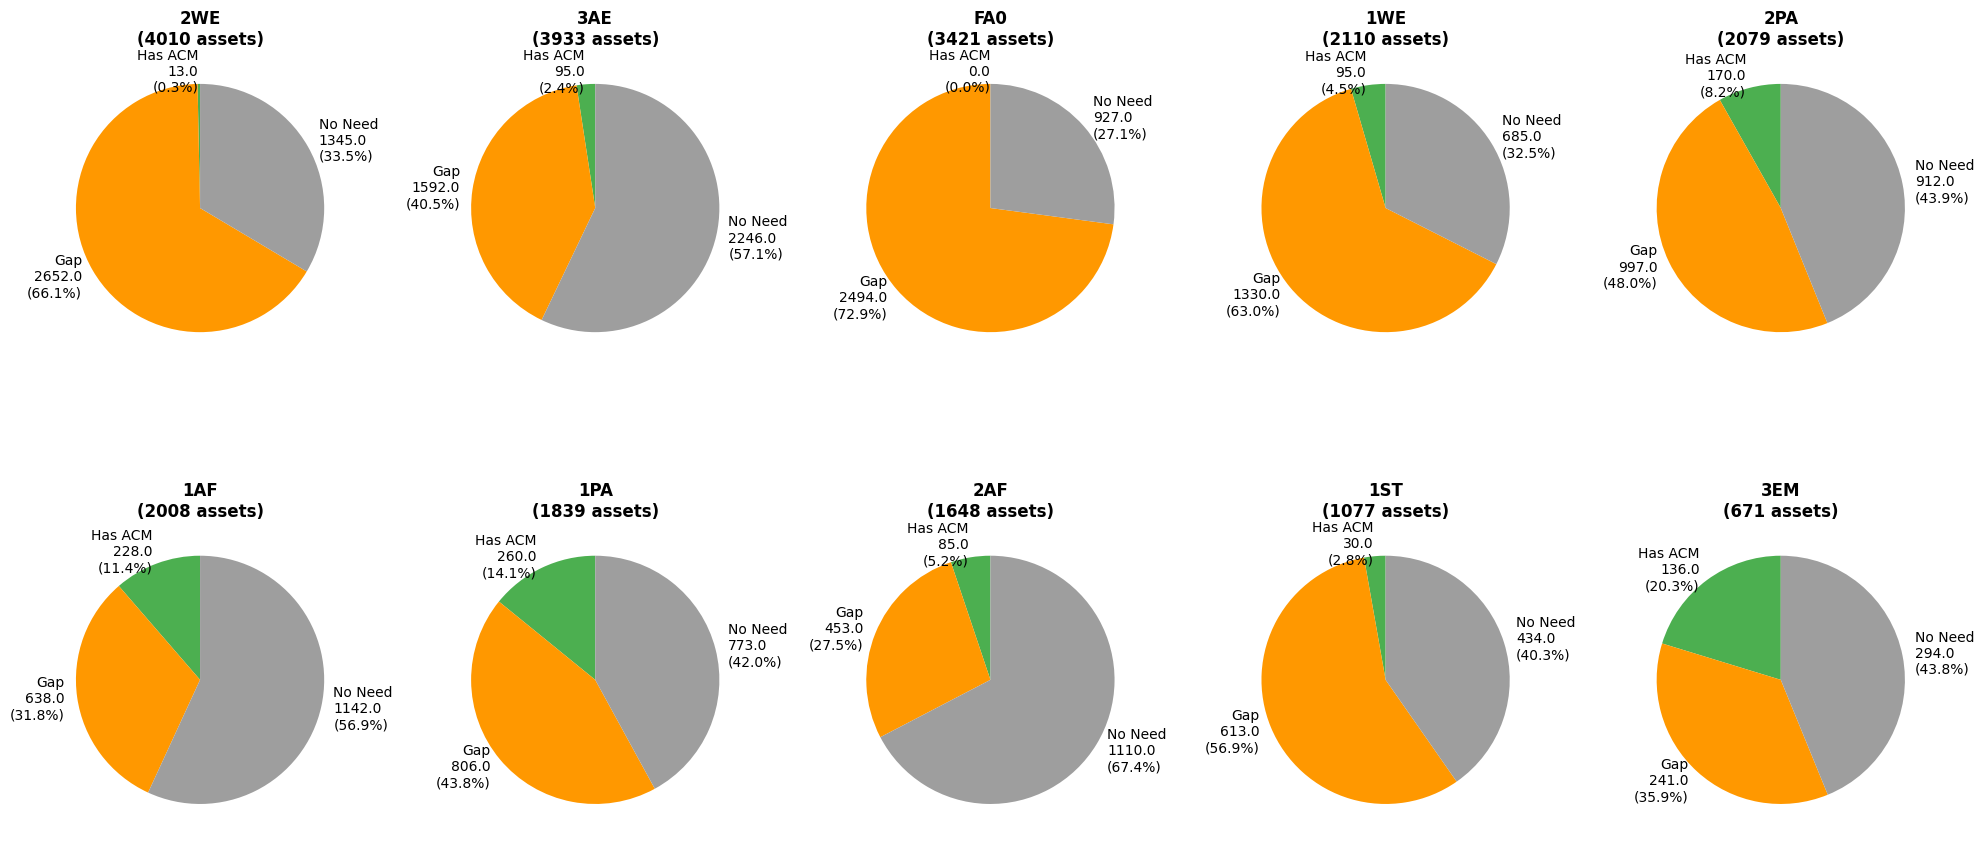


✓ Chart saved as acm_coverage_by_dept.png


In [9]:
# Cell: Department-level coverage analysis with pie charts
import matplotlib.pyplot as plt

# Calculate department-level statistics
dept_summary = df_matrix.groupby('DEPT').agg({
    'ASSETNUM': 'count',
    'NEED_ACM': lambda x: (x == 'Y').sum(),
    'HAS_ACM': lambda x: (x == 'Y').sum(),
    'ACM_GOOD': lambda x: (x == 'Y').sum()
}).rename(columns={
    'ASSETNUM': 'Total_Assets',
    'NEED_ACM': 'Need_ACM',
    'HAS_ACM': 'Has_ACM',
    'ACM_GOOD': 'Good_Coverage'
})

# Calculate percentages
dept_summary['Need_ACM_Pct'] = (dept_summary['Need_ACM'] / dept_summary['Total_Assets'] * 100).round(1)
dept_summary['Has_ACM_Pct'] = (dept_summary['Has_ACM'] / dept_summary['Total_Assets'] * 100).round(1)
dept_summary['Good_Coverage_Pct'] = (dept_summary['Good_Coverage'] / dept_summary['Total_Assets'] * 100).round(1)

print("Department Summary:")
print(dept_summary.sort_values('Total_Assets', ascending=False))

# Create pie charts - top 10 departments by asset count
top_depts = dept_summary.nlargest(10, 'Total_Assets')

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for idx, (dept, row) in enumerate(top_depts.iterrows()):
    ax = axes[idx]
    
    # Calculate the numbers for pie chart
    need_acm = row['Need_ACM']
    has_acm = row['Has_ACM']
    no_need = row['Total_Assets'] - need_acm
    need_no_has = need_acm - has_acm
    
    # Data: [Has Coverage, Needs but No Coverage, No Need for ACM]
    sizes = [has_acm, need_no_has, no_need]
    labels = [
        f'Has ACM\n{has_acm}\n({row["Has_ACM_Pct"]:.1f}%)',
        f'Gap\n{need_no_has}\n({(need_no_has/row["Total_Assets"]*100):.1f}%)',
        f'No Need\n{no_need}\n({(no_need/row["Total_Assets"]*100):.1f}%)'
    ]
    colors = ['#4CAF50', '#FF9800', '#9E9E9E']  # Green, Orange, Gray
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
    ax.set_title(f'{dept}\n({int(row["Total_Assets"])} assets)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('acm_coverage_by_dept.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved as acm_coverage_by_dept.png")


ACM COVERAGE SUMMARY

Total Assets: 25,661
Assets Needing ACM: 14,232 (55.5%)
Assets with ACM: 1,181 (4.6%)
Assets with Adequate Coverage: 175 (0.7%)


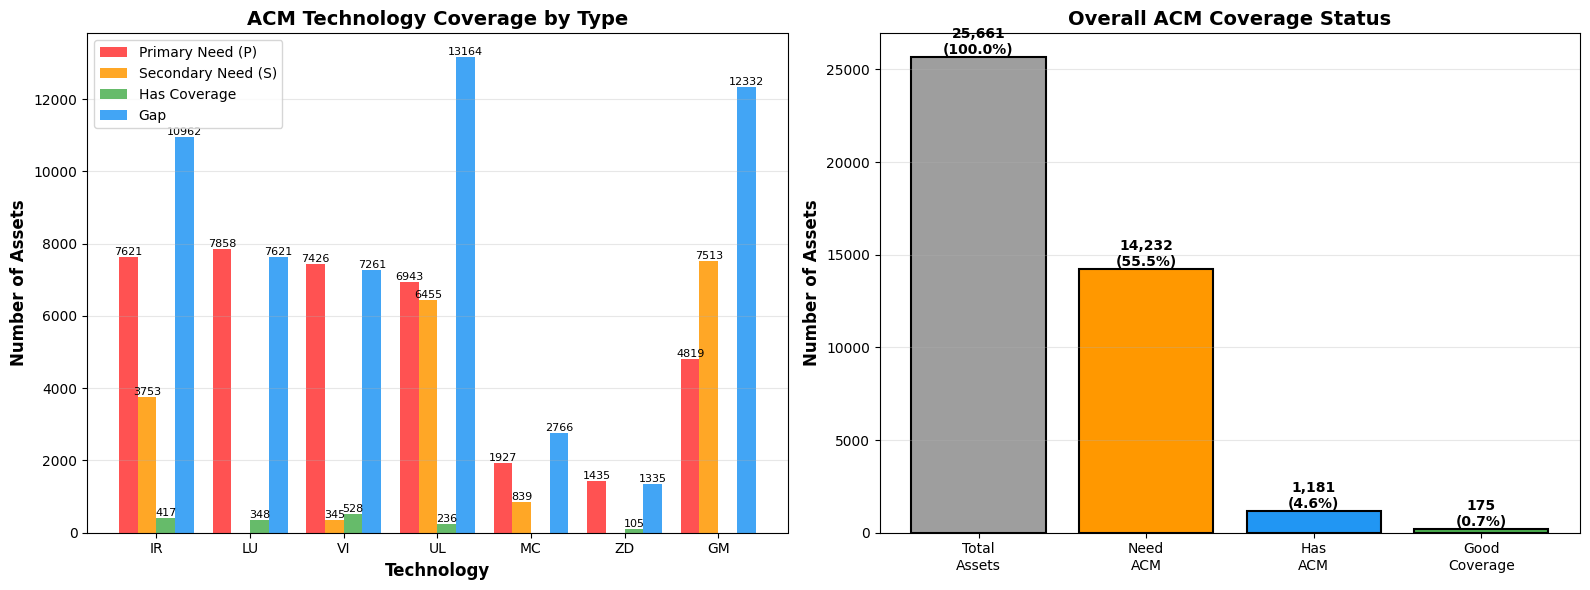


✓ Chart saved as acm_coverage_summary.png

--------------------------------------------------------------------------------
TECHNOLOGY-SPECIFIC GAPS (Detailed)
(P = Primary application, S = Secondary application)
--------------------------------------------------------------------------------

IR:
  Primary Need (P): 7,621
  Secondary Need (S): 3,753
  Currently Have: 417
  Gap: 10,962

LU:
  Primary Need (P): 7,858
  Secondary Need (S): 0
  Currently Have: 348
  Gap: 7,621

VI:
  Primary Need (P): 7,426
  Secondary Need (S): 345
  Currently Have: 528
  Gap: 7,261

UL:
  Primary Need (P): 6,943
  Secondary Need (S): 6,455
  Currently Have: 236
  Gap: 13,164

MC:
  Primary Need (P): 1,927
  Secondary Need (S): 839
  Currently Have: 0
  Gap: 2,766

ZD:
  Primary Need (P): 1,435
  Secondary Need (S): 0
  Currently Have: 105
  Gap: 1,335

GM:
  Primary Need (P): 4,819
  Secondary Need (S): 7,513
  Currently Have: 0
  Gap: 12,332


In [10]:
# Cell: Summary statistics with bar charts
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("ACM COVERAGE SUMMARY")
print("="*80)

total_assets = len(df_matrix)
need_acm = (df_matrix['NEED_ACM'] == 'Y').sum()
has_acm = (df_matrix['HAS_ACM'] == 'Y').sum()
acm_good = (df_matrix['ACM_GOOD'] == 'Y').sum()

print(f"\nTotal Assets: {total_assets:,}")
print(f"Assets Needing ACM: {need_acm:,} ({need_acm/total_assets*100:.1f}%)")
print(f"Assets with ACM: {has_acm:,} ({has_acm/total_assets*100:.1f}%)")
print(f"Assets with Adequate Coverage: {acm_good:,} ({acm_good/total_assets*100:.1f}%)")

# Create bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Technology-specific gaps
tech_data = []
for tech in tech_cols:
    need_primary = (df_matrix[f'{tech}_NEED'] == 'P').sum()
    need_secondary = (df_matrix[f'{tech}_NEED'] == 'S').sum()
    has = (df_matrix[f'{tech}_HAS'] == 'Y').sum()
    gap = (df_matrix[f'{tech}_GAP'] == 'Y').sum()
    
    tech_data.append({
        'tech': tech,
        'primary': need_primary,
        'secondary': need_secondary,
        'has': has,
        'gap': gap
    })

tech_names = [d['tech'] for d in tech_data]
primary_needs = [d['primary'] for d in tech_data]
secondary_needs = [d['secondary'] for d in tech_data]
has_coverage = [d['has'] for d in tech_data]
gaps = [d['gap'] for d in tech_data]

x = np.arange(len(tech_names))
width = 0.2

bars1 = ax1.bar(x - 1.5*width, primary_needs, width, label='Primary Need (P)', color='#FF5252')
bars2 = ax1.bar(x - 0.5*width, secondary_needs, width, label='Secondary Need (S)', color='#FFA726')
bars3 = ax1.bar(x + 0.5*width, has_coverage, width, label='Has Coverage', color='#66BB6A')
bars4 = ax1.bar(x + 1.5*width, gaps, width, label='Gap', color='#42A5F5')

ax1.set_xlabel('Technology', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Assets', fontsize=12, fontweight='bold')
ax1.set_title('ACM Technology Coverage by Type', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(tech_names)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=8)

# Chart 2: Overall coverage summary
categories = ['Total\nAssets', 'Need\nACM', 'Has\nACM', 'Good\nCoverage']
values = [total_assets, need_acm, has_acm, acm_good]
colors = ['#9E9E9E', '#FF9800', '#2196F3', '#4CAF50']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Assets', fontsize=12, fontweight='bold')
ax2.set_title('Overall ACM Coverage Status', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels and percentages
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    pct = (val / total_assets * 100) if i > 0 else 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('acm_coverage_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved as acm_coverage_summary.png")

# Print detailed table
print("\n" + "-"*80)
print("TECHNOLOGY-SPECIFIC GAPS (Detailed)")
print("(P = Primary application, S = Secondary application)")
print("-"*80)
for d in tech_data:
    print(f"\n{d['tech']}:")
    print(f"  Primary Need (P): {d['primary']:,}")
    print(f"  Secondary Need (S): {d['secondary']:,}")
    print(f"  Currently Have: {d['has']:,}")
    print(f"  Gap: {d['gap']:,}")